In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Change to corresponding values
dpu_depth = 0
task_depth = 22

dlinear = False
tlinear = True

dpus = [i for i in range(dpu_depth + 1)]
if not dlinear:
    dpus = [1 << i for i in dpus]
    
tasks = [i for i in range(task_depth + 1)]
if not tlinear:
    tasks = [1 << i for i in tasks]

algorithms = ["loop", "xs32", "mt32", "sc32", "lm32", "pcg32", "cha32"]

rng_data_file = "data/rng_dpus_{}_tasklets_{}.csv".format(dpu_depth, task_depth)

rng_data = pd.read_csv(rng_data_file)
#data = data[data.nr_dpu != "cpu"]

# Fix Bitflip of first 28 Bits
rng_data["cycles_per_sec"] = rng_data["cycles"] / rng_data["time"]
rng_data["time"] = np.where(rng_data["time"] > (2 ** 35), (rng_data["cycles"] - 18446744004990074880) / rng_data["cycles_per_sec"], rng_data["time"])

# Very bad way to subtract the `loop` time from all the other times
nr_dpus = []
nr_tasks = []
dpu_ids = []
task_ids = []
loop_times = []
for nr_dpu in dpus:
    for nr_task in tasks:
        for dpu_id in range(nr_dpu):
            for task_id in range(nr_task):
                nr_dpus.append(str(nr_dpu))
                nr_tasks.append(nr_task)
                dpu_ids.append(str(dpu_id))
                task_ids.append(task_id)
                loop_times.append(rng_data.loc[
                    (rng_data["nr_dpu"] == str(nr_dpu)) &
                    (rng_data["nr_tasklet"] == nr_task) & 
                    (rng_data["dpu_id"] == str(dpu_id)) & 
                    (rng_data["tasklet_id"] == task_id) &
                    (rng_data["algorithm"] == "loop") 
                ].iloc[0]["time"])

su_nr_tasks = []
su_task_ids = []
su_algos    = []
speedups    = []

for nr_task in tasks:
    for task_id in range(nr_task):
        nr_dpus.append("cpu")
        nr_tasks.append(nr_task)
        dpu_ids.append("cpu")
        task_ids.append(task_id)
        loop_times.append(rng_data.loc[
            (rng_data["nr_dpu"] == "cpu") &
            (rng_data["nr_tasklet"] == nr_task) & 
            (rng_data["dpu_id"] == "cpu") & 
            (rng_data["tasklet_id"] == task_id) &
            (rng_data["algorithm"] == "loop") 
        ].iloc[0]["time"])

        for algo in algorithms:
            su_nr_tasks.append(nr_task)
            su_task_ids.append(task_id)
            su_algos.append(algo)
            speedups.append((rng_data.loc[
                (rng_data["nr_dpu"] == "1") &
                (rng_data["nr_tasklet"] == nr_task) & 
                (rng_data["dpu_id"] == "0") & 
                (rng_data["tasklet_id"] == task_id) &
                (rng_data["algorithm"] == algo) 
            ].iloc[0]["time"]) / (rng_data.loc[
                (rng_data["nr_dpu"] == "cpu") &
                (rng_data["nr_tasklet"] == nr_task) & 
                (rng_data["dpu_id"] == "cpu") & 
                (rng_data["tasklet_id"] == task_id) &
                (rng_data["algorithm"] == algo) 
            ].iloc[0]["time"]))

rng_speedup_data = pd.DataFrame.from_dict({"nr_tasklet": su_nr_tasks, "tasklet_id": su_task_ids, "algorithm": su_algos, "speedup": speedups})

rng_loop_data = pd.DataFrame.from_dict({"nr_dpu": nr_dpus, "nr_tasklet": nr_tasks, "dpu_id": dpu_ids, "tasklet_id": task_ids, "loop_time": loop_times})
rng_data = rng_data.merge(rng_loop_data, on=["nr_dpu","nr_tasklet","dpu_id","tasklet_id"])

rng_data["clean_time"] = rng_data["time"] - rng_data["loop_time"]

rng_data["bytes_per_sec_per_tasklet"] = (4 * 1e7) / rng_data["time"]
rng_data["bytes_per_sec"] = rng_data["bytes_per_sec_per_tasklet"] * rng_data["nr_tasklet"]


In [17]:
def plot_dpu_rng():
    sns.lineplot(data = rng_data[rng_data.nr_dpu != "cpu"], x = "nr_tasklet", y = "time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for 1e7 Repeats on 1 DPU")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = rng_data[(rng_data.algorithm != "loop") & (rng_data.nr_dpu != "cpu")], x = "nr_tasklet", y = "clean_time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for 1e7 Repeats on 1 DPU (clean)")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = rng_data[(rng_data.algorithm != "loop") & (rng_data.nr_dpu != "cpu")], x = "nr_tasklet", y = "bytes_per_sec", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second generated on 1 DPU")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Bytes per Second")

    plt.show()


    sns.lineplot(data = rng_data[(rng_data.algorithm != "loop") & (rng_data.nr_dpu != "cpu")], x = "nr_tasklet", y = "bytes_per_sec_per_tasklet", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second per Tasklet generated on 1 DPU")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Bytes per Second per Tasklet")

    plt.show()


def plot_cpu_rng():
    sns.lineplot(data = rng_data[rng_data.nr_dpu == "cpu"], x = "nr_tasklet", y = "time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for 1e7 Repeats on CPU")
    plt.xlabel("Number of Threads")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = rng_data[(rng_data.algorithm != "loop") & (rng_data.nr_dpu == "cpu")], x = "nr_tasklet", y = "clean_time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for 1e7 Repeats on CPU (clean)")
    plt.xlabel("Number of Threads")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = rng_data[(rng_data.algorithm != "loop") & (rng_data.nr_dpu == "cpu")], x = "nr_tasklet", y = "bytes_per_sec", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second generated on CPU")
    plt.xlabel("Number of Threads")
    plt.ylabel("Bytes per Second")

    plt.show()


    sns.lineplot(data = rng_data[(rng_data.algorithm != "loop") & (rng_data.nr_dpu == "cpu")], x = "nr_tasklet", y = "bytes_per_sec_per_tasklet", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second per Thread generated on CPU")
    plt.xlabel("Number of Threads")
    plt.ylabel("Bytes per Second per Thread")

    plt.show()


def plot_speedup_rng():
    sns.lineplot(data = rng_speedup_data, x = "nr_tasklet", y = "speedup", hue = "algorithm")

    plt.yscale("log")

    plt.title("Speedup of CPU compare to DPU (per Tasklet)")
    plt.xlabel("Number of Threads/Tasklets")
    plt.ylabel("Speedup")

    plt.show()

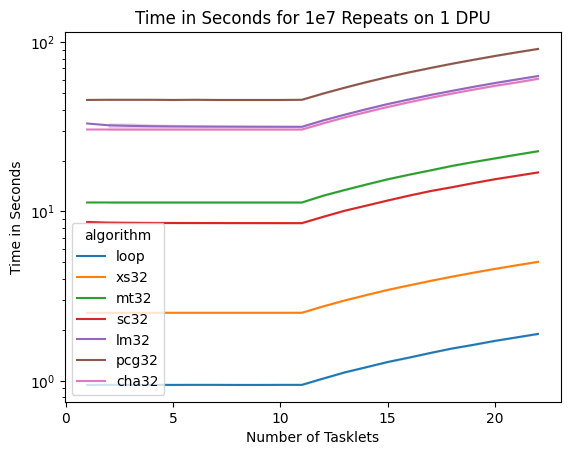

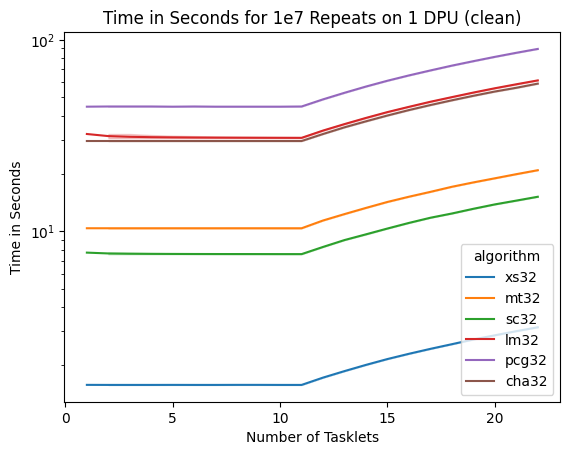

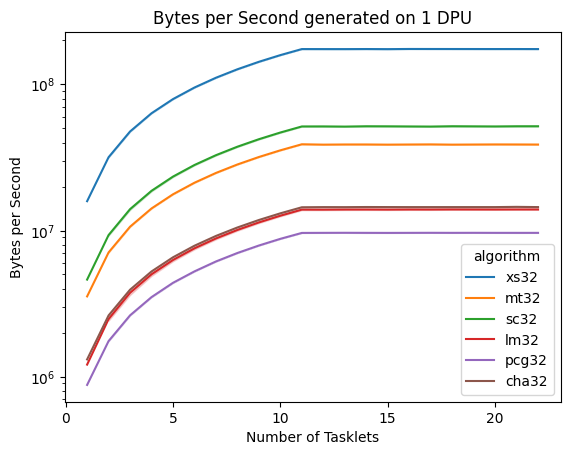

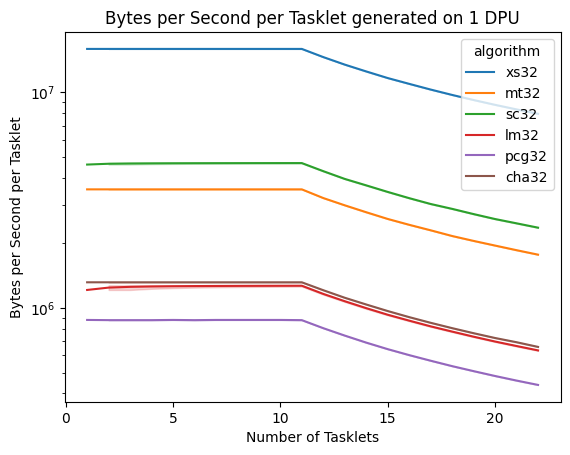

In [18]:
plot_dpu_rng()

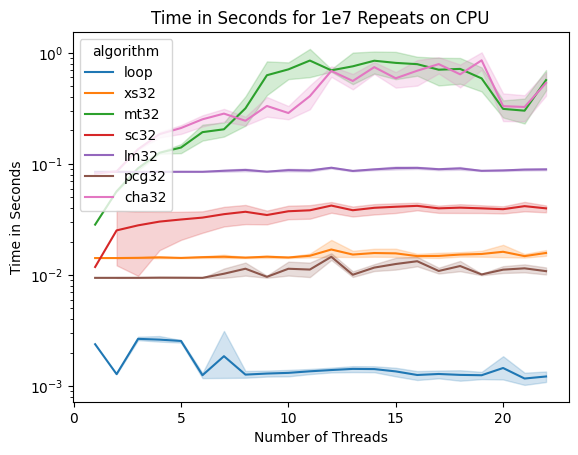

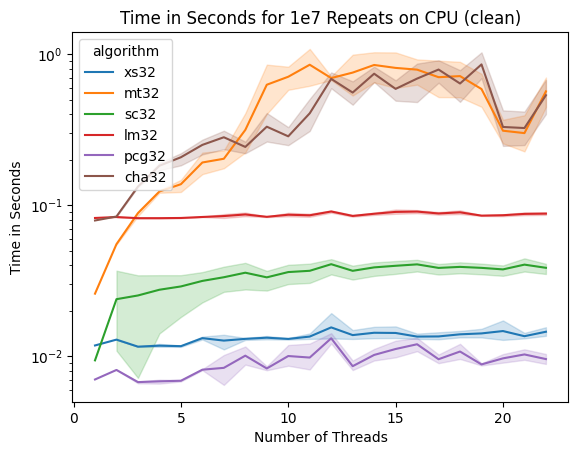

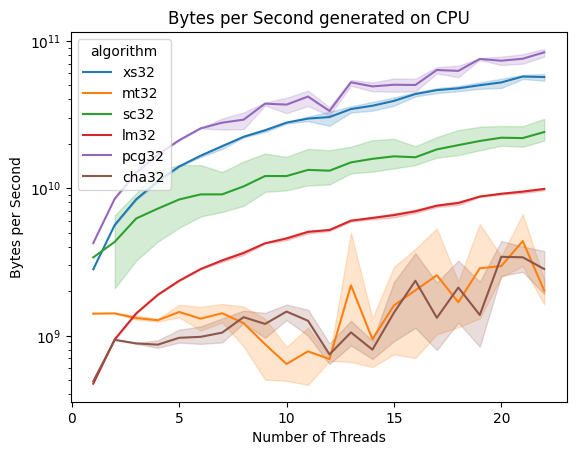

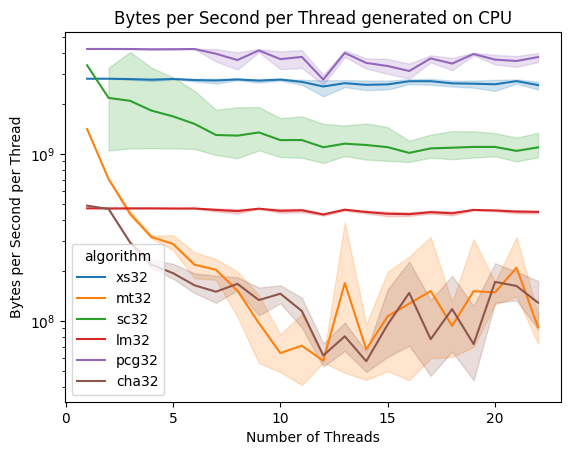

In [19]:
plot_cpu_rng()

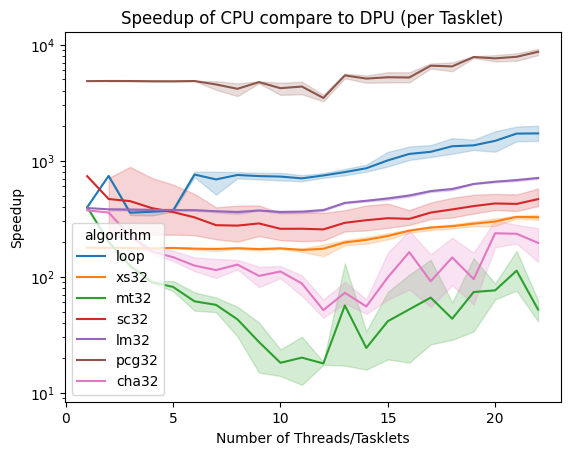

In [20]:
plot_speedup_rng()

In [2]:
# Change to corresponding values
dpu_depth = 0
task_depth = 22

dlinear = False
tlinear = True

dpus = [i for i in range(dpu_depth + 1)]
if not dlinear:
    dpus = [1 << i for i in dpus]
    
tasks = [i for i in range(task_depth + 1)]
if not tlinear:
    tasks = [1 << i for i in tasks]

algorithms = ["loop", "openbsd", "java", "lemire", "flips", "rr"]

data_file = "data/sampling_dpus_{}_tasklets_{}.csv".format(dpu_depth, task_depth)

data = pd.read_csv(data_file)
#data = data[data.nr_dpu != "cpu"]

# Fix Bitflip of first 28 Bits
data["cycles_per_sec"] = data["cycles"] / data["time"]
data["time"] = np.where(data["time"] > (2 ** 35), (data["cycles"] - 18446744004990074880) / data["cycles_per_sec"], data["time"])

# Very bad way to subtract the `loop` time from all the other times
nr_dpus = []
nr_tasks = []
dpu_ids = []
task_ids = []
loop_times = []
for nr_dpu in dpus:
    for nr_task in tasks:
        for dpu_id in range(nr_dpu):
            for task_id in range(nr_task):
                nr_dpus.append(str(nr_dpu))
                nr_tasks.append(nr_task)
                dpu_ids.append(str(dpu_id))
                task_ids.append(task_id)
                loop_times.append(data.loc[
                    (data["nr_dpu"] == str(nr_dpu)) &
                    (data["nr_tasklet"] == nr_task) & 
                    (data["dpu_id"] == str(dpu_id)) & 
                    (data["tasklet_id"] == task_id) &
                    (data["algorithm"] == "loop") 
                ].iloc[0]["time"])

su_nr_tasks = []
su_task_ids = []
su_algos    = []
speedups    = []

for nr_task in tasks:
    for task_id in range(nr_task):
        nr_dpus.append("cpu")
        nr_tasks.append(nr_task)
        dpu_ids.append("cpu")
        task_ids.append(task_id)
        loop_times.append(data.loc[
            (data["nr_dpu"] == "cpu") &
            (data["nr_tasklet"] == nr_task) & 
            (data["dpu_id"] == "cpu") & 
            (data["tasklet_id"] == task_id) &
            (data["algorithm"] == "loop") 
        ].iloc[0]["time"])

        for algo in algorithms:
            su_nr_tasks.append(nr_task)
            su_task_ids.append(task_id)
            su_algos.append(algo)
            speedups.append((data.loc[
                (data["nr_dpu"] == "1") &
                (data["nr_tasklet"] == nr_task) & 
                (data["dpu_id"] == "0") & 
                (data["tasklet_id"] == task_id) &
                (data["algorithm"] == algo) 
            ].iloc[0]["time"]) / (data.loc[
                (data["nr_dpu"] == "cpu") &
                (data["nr_tasklet"] == nr_task) & 
                (data["dpu_id"] == "cpu") & 
                (data["tasklet_id"] == task_id) &
                (data["algorithm"] == algo) 
            ].iloc[0]["time"]))

speedup_data = pd.DataFrame.from_dict({"nr_tasklet": su_nr_tasks, "tasklet_id": su_task_ids, "algorithm": su_algos, "speedup": speedups})

loop_data = pd.DataFrame.from_dict({"nr_dpu": nr_dpus, "nr_tasklet": nr_tasks, "dpu_id": dpu_ids, "tasklet_id": task_ids, "loop_time": loop_times})
data = data.merge(loop_data, on=["nr_dpu","nr_tasklet","dpu_id","tasklet_id"])

data["clean_time"] = data["time"] - data["loop_time"]

data["bytes_per_sec_per_tasklet"] = (4 * 1e7) / data["time"]
data["bytes_per_sec"] = data["bytes_per_sec_per_tasklet"] * data["nr_tasklet"]


In [12]:
def plot_dpu_sampling():
    sns.lineplot(data = data[data.nr_dpu != "cpu"], x = "nr_tasklet", y = "time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for s=2..1e7 on 1 DPU")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = data[(data.algorithm != "loop") & (data.nr_dpu != "cpu")], x = "nr_tasklet", y = "clean_time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for s=2..1e7 on 1 DPU (clean)")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = data[(data.algorithm != "loop") & (data.nr_dpu != "cpu")], x = "nr_tasklet", y = "bytes_per_sec", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second generated on 1 DPU")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Bytes per Second")

    plt.show()


    sns.lineplot(data = data[(data.algorithm != "loop") & (data.nr_dpu != "cpu")], x = "nr_tasklet", y = "bytes_per_sec_per_tasklet", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second per Tasklet generated on 1 DPU")
    plt.xlabel("Number of Tasklets")
    plt.ylabel("Bytes per Second per Tasklet")

    plt.show()


def plot_cpu_sampling():
    sns.lineplot(data = data[data.nr_dpu == "cpu"], x = "nr_tasklet", y = "time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for s=2..1e7 on CPU")
    plt.xlabel("Number of Threads")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = data[(data.algorithm != "loop") & (data.nr_dpu == "cpu")], x = "nr_tasklet", y = "clean_time", hue = "algorithm")

    plt.yscale("log")

    plt.title("Time in Seconds for s=2..1e7 on CPU (clean)")
    plt.xlabel("Number of Threads")
    plt.ylabel("Time in Seconds")

    plt.show()


    sns.lineplot(data = data[(data.algorithm != "loop") & (data.nr_dpu == "cpu")], x = "nr_tasklet", y = "bytes_per_sec", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second generated on CPU")
    plt.xlabel("Number of Threads")
    plt.ylabel("Bytes per Second")

    plt.show()


    sns.lineplot(data = data[(data.algorithm != "loop") & (data.nr_dpu == "cpu")], x = "nr_tasklet", y = "bytes_per_sec_per_tasklet", hue = "algorithm")

    plt.yscale("log")

    plt.title("Bytes per Second per Thread generated on CPU")
    plt.xlabel("Number of Threads")
    plt.ylabel("Bytes per Second per Thread")

    plt.show()


def plot_speedup_sampling():
    sns.lineplot(data = speedup_data, x = "nr_tasklet", y = "speedup", hue = "algorithm")

    plt.yscale("log")

    plt.title("Speedup of CPU compare to DPU (per Tasklet)")
    plt.xlabel("Number of Threads/Tasklets")
    plt.ylabel("Speedup")

    plt.show()

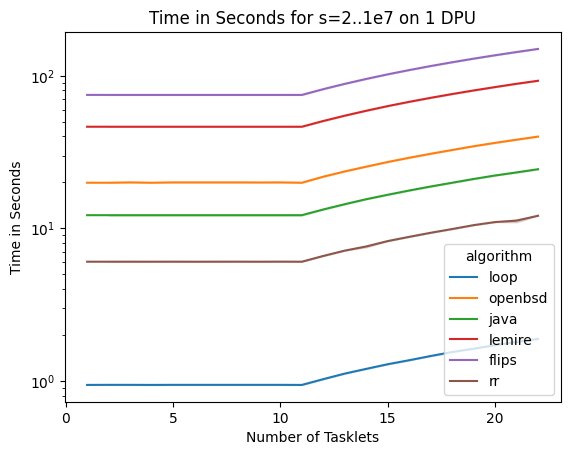

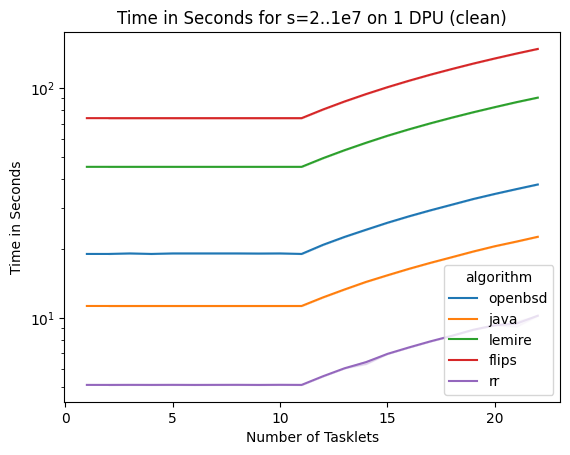

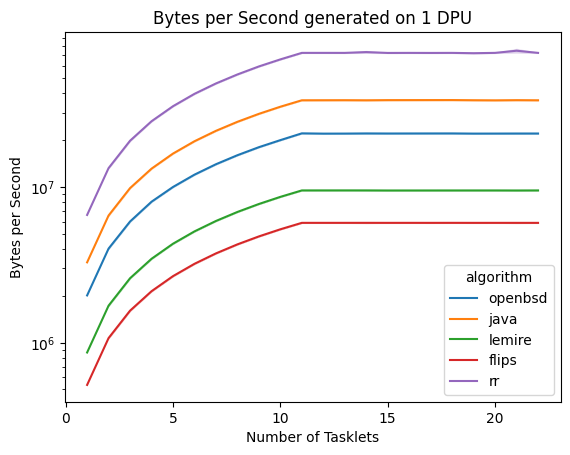

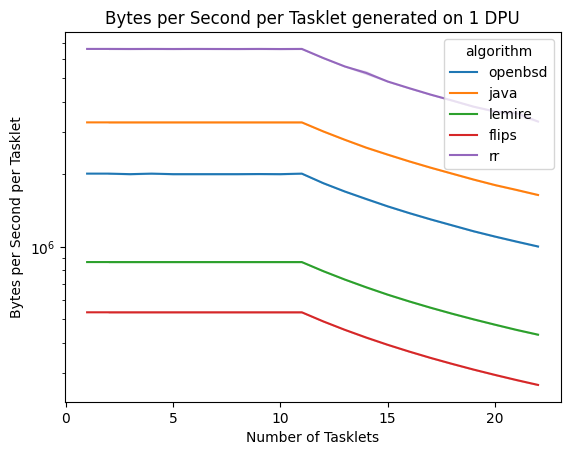

In [13]:
plot_dpu_sampling()

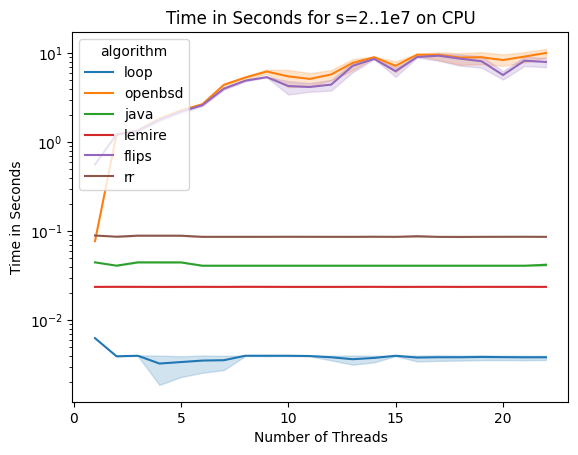

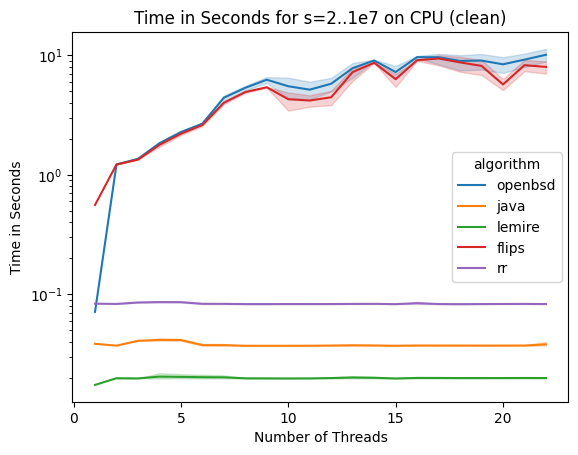

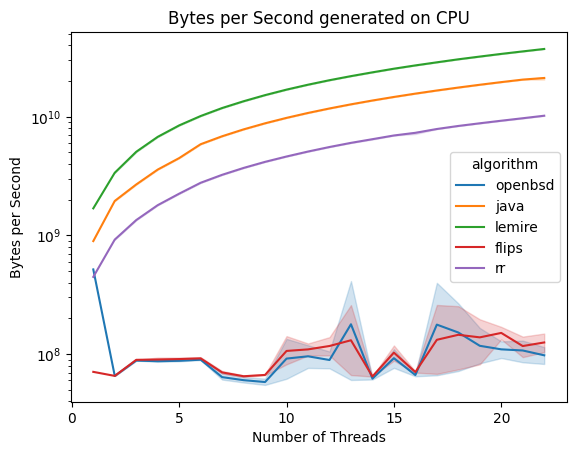

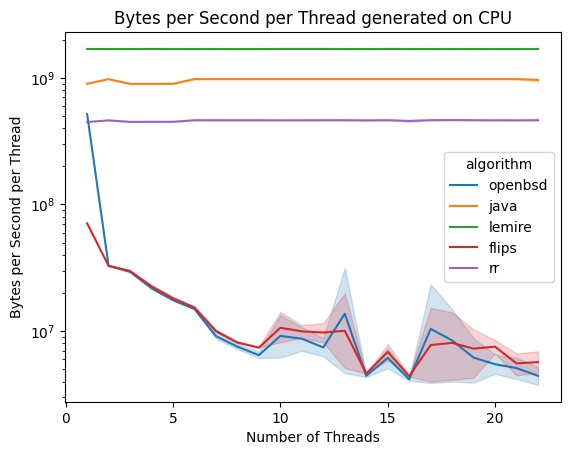

In [14]:
plot_cpu_sampling()

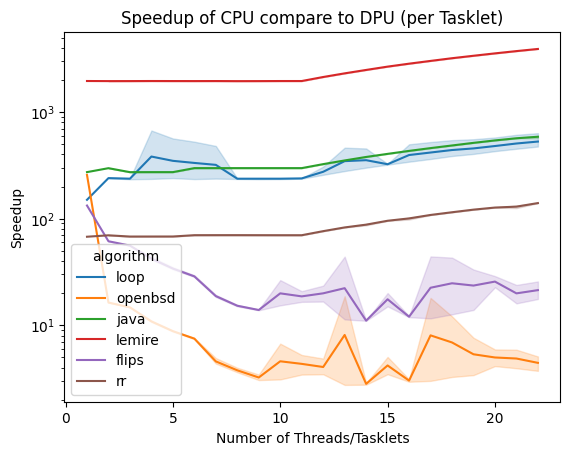

In [11]:
plot_speedup_sampling()